In [16]:
'''
Description: TP2 de cours EDP in finance
Version: 1.0
Author: SHAO Nuoya
Date: 2021-12-17 14:01:37
LastEditors: SHAO Nuoya
LastEditTime: 2021-12-17 14:03:57
'''

'\nDescription: TP2 de cours EDP in finance\nVersion: 1.0\nAuthor: SHAO Nuoya\nDate: 2021-12-17 14:01:37\nLastEditors: SHAO Nuoya\nLastEditTime: 2021-12-17 14:03:57\n'

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve

In [18]:
class BS:
    def __init__(self,
                 K=100,
                 S_min=50,
                 S_max=250,
                 T=1,
                 sigma=0.3,
                 r=0.1,
                 N=10,
                 I=10):
        self.K = K
        self.S_min = S_min
        self.S_max = S_max
        self.T = T
        self.sigma = sigma
        self.r = r
        self.N = N
        self.I = I

        self.h = (S_max - S_min) / (I + 1)
        self.dt = T / N

        self.S = S_min + self.h * np.arange(1, I + 1).reshape(-1, 1)
        self.Sval = 90
        self.alpha = sigma**2 * self.S**2 / (2 * self.h**2)
        self.beta = r * self.S / (2 * self.h)

    # Calculate matrix A
    def get_A(self) -> np.ndarray:
        I = self.I
        A = np.zeros((I, I))
        for i in range(I):
            A[i, i] = 2 * self.alpha[i] + self.r

        for i in range(I - 1):
            A[i + 1, i] = -self.alpha[i + 1] + self.beta[i + 1]
            A[i, i + 1] = -self.alpha[i] - self.beta[i]
        return sparse(A)

    # payoff 1
    def phi(self) -> np.ndarray:
        return np.maximum(self.K - self.S, 0).reshape(-1, 1)

    # payoff 2
    def phi2(self) -> np.ndarray:
        K, S = self.K, self.S-50
        n = S.shape[0]
        ans = np.array([0 for _ in range(n)]).reshape(-1, 1)

        ans[((K / 2 <= S) & (S <= K))] = K
        return ans

    # boundary condition for payoff 1
    def uleft(self) -> float:
        return (-self.alpha[0] + self.beta[0]) * (self.K - self.S_min)
    def uright(self) -> float:
        return 0

    # boundary condition for payoff 2
    def uleft2(self) -> float:
        return 0
    def uright2(self) -> float:
        return 0

    def PSOR(self, x0: np.ndarray, B: np.ndarray, b: np.ndarray, g: np.ndarray,
             eta: float, k_max: int) -> np.ndarray:
        x = x0.copy()
        k = 0
        err = 1
        errs = [err]
        while (errs[-1] > eta and k < k_max):
            x_old = x.copy()
            for i in range(len(x)):
                x[i] = (b[i] - ((B @ x)[i] - B[i, i] * x[i])) / B[i, i]
                x[i] = max(x[i], g[i])

            err = np.linalg.norm(np.abs(x - x_old), np.inf)
            
            k += 1
            errs.append(round(err, 5))
        return x, errs

    def newton(self, x: np.ndarray, B: np.ndarray, b: np.ndarray, eta: float,
               k_max: int) -> np.ndarray:
        g = self.phi()
        k = 0
        err = 1
        errs = [err]
        F_prime = np.eye(B.shape[0])

        while (errs[-1] > eta and k < k_max):
            for i in range(B.shape[0]):
                if (B @ x - b)[i][0] <= (x - g)[i]:
                    F_prime[i] = B[i]

            x_new = x - np.linalg.inv(F_prime) @ np.minimum(B @ x - b, x - g)
            err = np.linalg.norm(np.abs(x_new - x), np.inf)
            x = x_new.copy()
            k += 1
            errs.append(round(err, 5))
        return x, errs

    # UL decomposition
    def uldecomp(self, B: np.ndarray) -> list[np.ndarray]:
        rows, columns = np.shape(B)
        L = np.zeros((rows, columns))
        U = np.zeros((rows, columns))
        if rows != columns:
            return
        for i in range(columns):
            for j in range(i - 1):
                sum = 0
                for k in range(j - 1):
                    sum += L[i,k] * U[k,j]
                L[i,j] = (B[i,j] - sum) / U[j,j]
            L[i,i] = 1
            for j in range(i - 1, columns):
                sum1 = 0
                for k in range(i - 1):
                    sum1 += L[i,k] * U[k,j]
                U[i,j] = B[i,j] - sum1
        return L, U

    def descente_p(self, x, L, c, g, eta, k_max):
        return self.PSOR(x, L, c, g, eta, k_max)[0]

    # calculate option price
    def get_price(self, method: str, payoff=1) -> np.ndarray:
        I, dt, g, A = self.I, self.dt, self.phi(), self.get_A()
        U = self.phi()
        q = np.zeros((I, 1))
        q[0] = self.uleft()
        q[-1] = self.uright()
        B = np.eye(I) + dt * A
            
        if method == 'EE':
            for t in range(self.N):
                U = np.maximum(U - dt * (A @ U + q), g)

        if method == 'IE':
            for t in range(self.N):
                Id = sparse(np.eye(I))
                U1 = spsolve(A + Id / dt, Id / dt @ U - q)
                U1 = U1.reshape(I, 1)
                U = np.maximum(U1, g)

        if method == 'CN':
            for t in range(self.N):
                Id = sparse(np.eye(I))
                U1 = spsolve(A / 2 + Id / dt, (-A / 2 + Id / dt) @ U - q)
                U1 = U1.reshape(I, 1)
                U = np.maximum(U1, g)

        if method == 'EI-AMER-PSOR':
            for t in range(self.N):
                b = U - dt * q
                U, errs = self.PSOR(U, B, b, g, 0.0001, 100)
            print(f"Errors : \n", errs, '\n')
            
        if method == 'Semi-Smooth-Newton':
            for t in range(self.N):
                b = U - dt * q
                U, errs = self.newton(U, B, b, 0.0001, 100)
            print(f"Errors : \n", errs, '\n')

        if method == 'EI-AMER-UL':
            if payoff == 2:
                q[0] = self.uleft2()
                q[-1] = self.uright2()
                g = self.phi2()
            
            l, u = self.uldecomp(B)
            for t in range(self.N):
                b = U - dt * q
                if t == 0:
                    print('norm de B-UL: ', np.linalg.norm(B - u @ l, np.inf))
                c = np.linalg.inv(u) @ b
                U = self.descente_p(U, l, c, g, 0.0001, 100)
            err = np.linalg.norm(np.minimum(B@U - (U - dt * q), U-g), np.inf)
            print(f'Check: |min(Bx - b, x - g)|_inf = {err}|')

        if method == 'BDF':
            Id = np.eye(I)
            B_ = 3 * Id / 2 + dt * A
            
            # compute U1 with EI schema 
            U0 = g.copy()
            U = spsolve(sparse(A + Id / dt), sparse(Id / dt @ U0 - q))
            U = U.reshape(I, 1)
            U = np.maximum(U, g)
            
            for t in range(1, self.N):      
                b_ = 2 * U - U0 / 2 - dt * q
                U0 = U.copy()
                U = self.PSOR(U, B_, b_, g, 0.0001, 100)[0]    

        return U

In [19]:
def plot(method: str, I: int, N: int, payoff=1) -> None:
    bs = BS(I=I, N=N)
    U = bs.get_price(method, payoff)

    plt.plot(bs.S, U)
    if payoff==1:
        plt.plot(bs.S, bs.phi(), linestyle='--')
    elif payoff==2:
        plt.plot(bs.S, bs.phi2(), linestyle='--')
    plt.title('I = {}, N = {}, K = {}'.format(bs.I, bs.N, bs.K))
    plt.xlabel('S0')
    plt.ylabel('Payoff')
    plt.grid()

In [20]:
def dic() -> dict:
    dic = {'I': [], 'N': [], 'U(s_)': [], 'e_k': [], 'order_alpha_k': []}
    return dic


def get_order_alpha(e_k_1, e_k, h_k_1, h_k) -> float:
    return np.log(abs(e_k_1 / e_k)) / np.log(h_k_1 / h_k)

def P1(s_bar, bs, method):
    U = bs.get_price(method).reshape(-1,1)

    for i in range(len(bs.S)):
        if bs.S[i] <= s_bar and bs.S[i + 1] >= s_bar:
            index = i
            break
    s_i = bs.S[index]
    s_ii = bs.S[index + 1]
    P1_S = (s_ii - s_bar) * U[index] / bs.h + (s_bar - s_i) * U[index +
                                                                1] / bs.h

    return np.array(P1_S).reshape(-1,1)[0][0]

In [21]:
def get_err_table(method, Is, Ns): 
    hs = []

    dictionary = dic()
    dictionary['e_k'].append(None)
    dictionary['order_alpha_k'].extend([None, None])

    for i in range(len(Is)):
        I = Is[i]
        N = Ns[i]
        print(f"I = {I}, N = {N}")
        
        bs = BS(N=N, I=I)
        s_ = bs.Sval
        U_s = P1(s_, bs, method)
        hs.append(bs.h)
        dictionary['I'].append(I)
        dictionary['N'].append(N)
        dictionary['U(s_)'].append(U_s)
        if i > 0:
            dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                    dictionary['U(s_)'][i - 1])
        if i > 1:
            e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
            h_k_1, h_k = hs[i - 1:i + 1]
            dictionary['order_alpha_k'].append(
                get_order_alpha(e_k_1, e_k, h_k_1, h_k))

    df = pd.DataFrame.from_dict(dictionary)
    return df

# 1. Explicit Euler Scheme

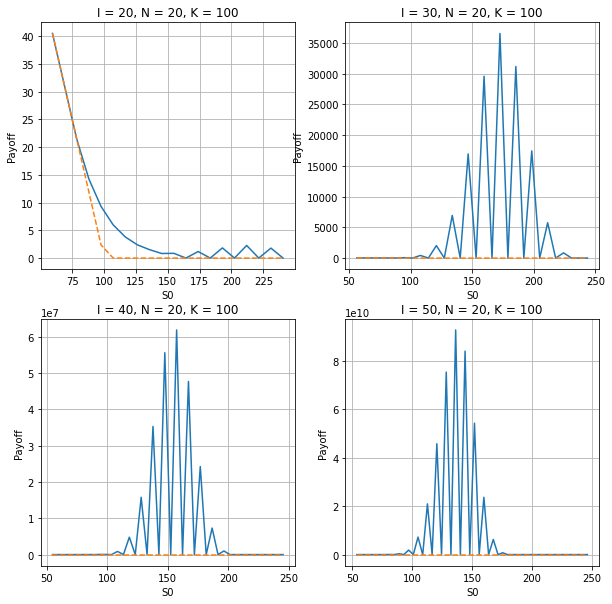

In [22]:
Is = [20, 30, 40, 50]
N = 20
  
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('EE', I, N)

In [23]:
Is = np.array([19, 39, 79, 159, 319])
Ns = 2*(Is+1)**2//10
err_table = get_err_table('EE', Is, Ns)
err_table.round(5)

I = 19, N = 80
I = 39, N = 320
I = 79, N = 1280
I = 159, N = 5120
I = 319, N = 20480


,I,N,U(s_),e_k,order_alpha_k
0,19,80,12.94710,NaN,NaN
1,39,320,13.06472,0.11762,NaN
2,79,1280,13.10957,0.04485,1.39078
3,159,5120,13.11780,0.00823,2.44578
4,319,20480,13.11999,0.00218,1.91530


# 2. A first implicit scheme: the splitting scheme

## SCHEME = 'EI-AMER-SPLIT'

In [24]:
Is = np.array([20*2**k-1 for k in range(6)])
Ns = Is + 1
err_table = get_err_table('IE', Is, Ns)
err_table.round(5)

I = 19, N = 20
I = 39, N = 40
I = 79, N = 80
I = 159, N = 160
I = 319, N = 320
I = 639, N = 640


,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.77115,NaN,NaN
1,39,40,12.95893,0.18778,NaN
2,79,80,13.05483,0.09590,0.96936
3,159,160,13.08979,0.03496,1.45603
4,319,320,13.10560,0.01581,1.14481
5,639,640,13.11323,0.00763,1.05141


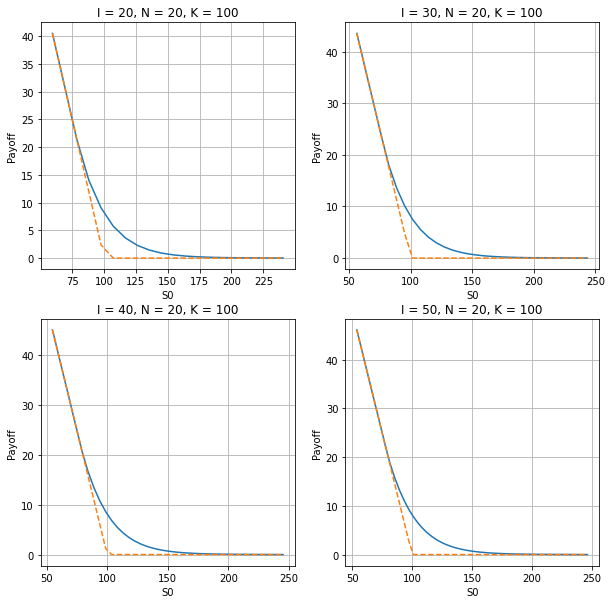

In [25]:
Is = [20, 30, 40, 50]
N = 20
  
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('IE', I, N)

## SCHEME = 'splitting-Crank-Nicolson'

In [26]:
Is = np.array([20*2**k-1 for k in range(6)])
Ns = Is + 1
err_table = get_err_table('CN', Is, Ns)
err_table.round(5)

I = 19, N = 20
I = 39, N = 40
I = 79, N = 80
I = 159, N = 160
I = 319, N = 320
I = 639, N = 640


,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.88885,NaN,NaN
1,39,40,13.02190,0.13305,NaN
2,79,80,13.09098,0.06908,0.94553
3,159,160,13.10781,0.01682,2.03795
4,319,320,13.11498,0.00717,1.22991
5,639,640,13.11799,0.00301,1.25097


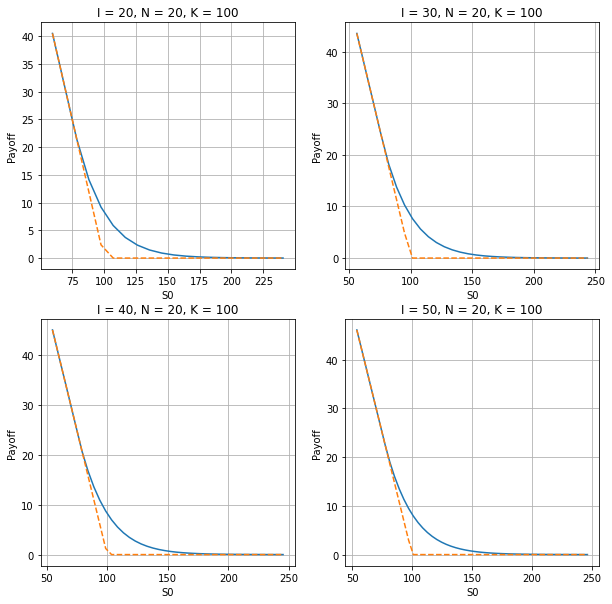

In [27]:
Is = [20, 30, 40, 50]
N = 20
  
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('CN', I, N)

# Implicit Euler Scheme

## 3.1 PSOR Algorithm (PSOR = 'Projected Successive Over Relaxation')

In [28]:
Is = np.array([20*2**k-1 for k in range(4)])
Ns = Is + 1
err_table = get_err_table('EI-AMER-PSOR', Is, Ns)
err_table.round(5)

I = 19, N = 20
Errors : 
 [1, 0.11905, 0.0237, 0.00492, 0.00113, 0.0003, 9e-05] 

I = 39, N = 40
Errors : 
 [1, 0.04795, 0.01604, 0.0057, 0.00217, 0.00089, 0.00039, 0.00018, 9e-05] 

I = 79, N = 80
Errors : 
 [1, 0.01789, 0.00886, 0.00455, 0.00244, 0.00136, 0.00079, 0.00047, 0.00029, 0.00018, 0.00012, 8e-05] 

I = 159, N = 160
Errors : 
 [1, 0.006, 0.00392, 0.00261, 0.00177, 0.00123, 0.00086, 0.00062, 0.00045, 0.00033, 0.00025, 0.00019, 0.00014, 0.00011, 9e-05] 



,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.86715,NaN,NaN
1,39,40,13.02670,0.15955,NaN
2,79,80,13.08904,0.06234,1.35575
3,159,160,13.10107,0.01203,2.37414


Errors : 
 [1, 0.02582, 0.0234, 0.02128, 0.01937, 0.01764, 0.01608, 0.0147, 0.01344, 0.0123, 0.01127, 0.01035, 0.0095, 0.00873, 0.00804, 0.00741, 0.00683, 0.00631, 0.00583, 0.00539, 0.00499, 0.00463, 0.00429, 0.00398, 0.0037, 0.00344, 0.0032, 0.00298, 0.00278, 0.00259, 0.00242, 0.00226, 0.00212, 0.00198, 0.00186, 0.00174, 0.00163, 0.00153, 0.00144, 0.00135, 0.00127, 0.00119, 0.00113, 0.00106, 0.001, 0.00094, 0.00089, 0.00084, 0.00079, 0.00075, 0.00071, 0.00067, 0.00064, 0.0006, 0.00057, 0.00054, 0.00051, 0.00049, 0.00046, 0.00044, 0.00042, 0.0004, 0.00038, 0.00036, 0.00034, 0.00033, 0.00031, 0.0003, 0.00028, 0.00027, 0.00026, 0.00025, 0.00024, 0.00022, 0.00021, 0.00021, 0.0002, 0.00019, 0.00018, 0.00017, 0.00017, 0.00016, 0.00015, 0.00015, 0.00014, 0.00013, 0.00013, 0.00012, 0.00012, 0.00011, 0.00011, 0.0001] 



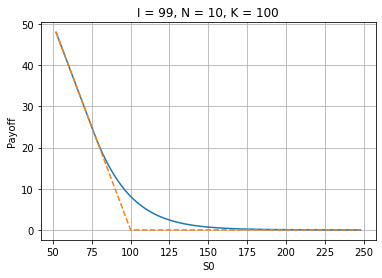

In [29]:
I = 99
N = 10
plot('EI-AMER-PSOR', I, N)

Errors : 
 [1, 0.00739, 0.00721, 0.00703, 0.00686, 0.00669, 0.00652, 0.00636, 0.00621, 0.00606, 0.00591, 0.00577, 0.00563, 0.0055, 0.00537, 0.00524, 0.00512, 0.005, 0.00488, 0.00477, 0.00466, 0.00455, 0.00445, 0.00435, 0.00425, 0.00415, 0.00406, 0.00396, 0.00388, 0.00379, 0.00371, 0.00362, 0.00354, 0.00346, 0.00339, 0.00331, 0.00324, 0.00317, 0.0031, 0.00304, 0.00297, 0.00291, 0.00285, 0.00278, 0.00273, 0.00267, 0.00261, 0.00256, 0.0025, 0.00245, 0.0024, 0.00235, 0.0023, 0.00226, 0.00221, 0.00216, 0.00212, 0.00208, 0.00204, 0.00199, 0.00195, 0.00192, 0.00188, 0.00184, 0.0018, 0.00177, 0.00173, 0.0017, 0.00167, 0.00163, 0.0016, 0.00157, 0.00154, 0.00151, 0.00148, 0.00145, 0.00143, 0.0014, 0.00137, 0.00135, 0.00132, 0.0013, 0.00127, 0.00125, 0.00123, 0.0012, 0.00118, 0.00116, 0.00114, 0.00112, 0.0011, 0.00108, 0.00106, 0.00104, 0.00102, 0.001, 0.00098, 0.00096, 0.00095, 0.00093, 0.00091] 



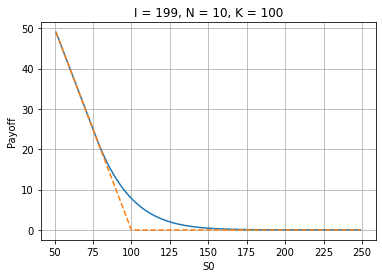

In [30]:
I = 199
N = 10
plot('EI-AMER-PSOR', I, N)

We see clearly that with larger I value, a more important number of PSOR iterations is needed (the length of errs is longer)

## 3.2 Semi-smooth Newton's method

Errors : 
 [1, 0.14693, 0.0] 



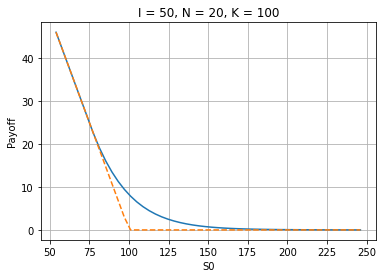

In [31]:
I = 50
N = 20
plot('Semi-Smooth-Newton', I, N)

In [32]:
Is = np.array([20*2**k for k in range(4)])
Ns = Is 
err_table = get_err_table('Semi-Smooth-Newton', Is, Ns)
err_table.round(5)

I = 20, N = 20
Errors : 
 [1, 0.14841, 0.0] 

I = 40, N = 40
Errors : 
 [1, 0.07177, 0.0] 

I = 80, N = 80
Errors : 
 [1, 0.03574, 0.0] 

I = 160, N = 160
Errors : 
 [1, 0.01777, 0.0] 



,I,N,U(s_),e_k,order_alpha_k
0,20,20,13.13780,NaN,NaN
1,40,40,13.08458,-0.05322,NaN
2,80,80,13.10656,0.02198,1.29887
3,160,160,13.11197,0.00541,2.03948


In [33]:
Is = np.array([20*2**k for k in range(6)])
Ns = Is//10
err_table = get_err_table('Semi-Smooth-Newton', Is, Ns)
err_table.round(5)

I = 20, N = 2
Errors : 
 [1, 1.98557, 0.0] 

I = 40, N = 4
Errors : 
 [1, 0.8471, 0.04163, 0.0] 

I = 80, N = 8
Errors : 
 [1, 0.38849, 0.0] 

I = 160, N = 16
Errors : 
 [1, 0.18547, 0.0] 

I = 320, N = 32
Errors : 
 [1, 0.09058, 0.0] 

I = 640, N = 64
Errors : 
 [1, 0.04475, 0.0] 



,I,N,U(s_),e_k,order_alpha_k
0,20,2,12.71962,NaN,NaN
1,40,4,12.83585,0.11623,NaN
2,80,8,12.96575,0.12990,-0.16323
3,160,16,13.03823,0.07248,0.84922
4,320,32,13.07776,0.03952,0.87895
5,640,64,13.09851,0.02075,0.93144


The Newton's method can get a more accurate result with the same N and I

## 3.3 Brennan and Schwartz algorithm

### Classical payoff function : $\phi_1$

In [34]:
Is = np.array([20*2**k-1 for k in range(5)])
Ns = Is + 1
err_table = get_err_table('EI-AMER-UL', Is, Ns)
err_table.round(5)

I = 19, N = 20
norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.14920626164745876|
I = 39, N = 40
norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.07178101832038575|
I = 79, N = 80
norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.035714119459486326|
I = 159, N = 160
norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.036983957577064075|
I = 319, N = 320
norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.013250748626141728|


,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.77115,NaN,NaN
1,39,40,12.95893,0.18778,NaN
2,79,80,13.05483,0.09590,0.96936
3,159,160,13.08979,0.03496,1.45603
4,319,320,13.10560,0.01581,1.14481


norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 0.2509393586004123|


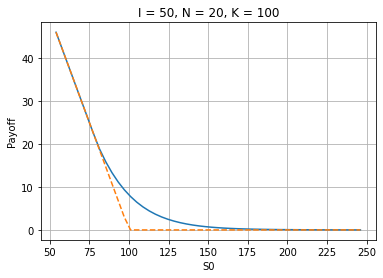

In [35]:
I = 50
N = 20
plot('EI-AMER-UL', I, N, payoff=1)

### Payoff function : $\phi_2$

norm de B-UL:  0.0
Check: |min(Bx - b, x - g)|_inf = 42.60404538710712|


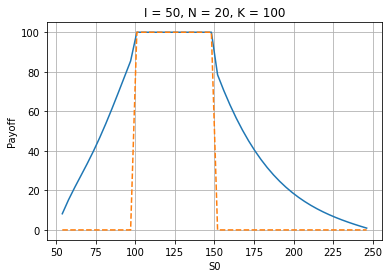

In [36]:
I = 50
N = 20
plot('EI-AMER-UL', I, N, payoff=2)

We see clearly that with payoff $\phi_2$, $min(Bx-b,\ x-g)\neq 0$

# 4 A higher order scheme

We have $$min(\frac{3U^{n+1}-4U^n+U^{n-1}}{2\Delta t}+AU^{n+1}+q(t_{n+1}), U^{n+1}-g)=0 $$

Note $$B:=\frac{3I_d}{2}+\Delta tA,\quad and\quad  b=2U^n-\frac{U^{n-1}}{2}-\Delta tq(t_{n+1})$$

Hence the problem can be transformed to 
$$min(Bx-b, x-g)=0, \quad in \ \mathbf{R}^I$$

### N = I

In [37]:
Is = np.array([20*2**k for k in range(4)])
Ns = Is
err_table = get_err_table('BDF', Is, Ns)
err_table.round(5)

I = 20, N = 20
I = 40, N = 40
I = 80, N = 80
I = 160, N = 160


,I,N,U(s_),e_k,order_alpha_k
0,20,20,13.19134,NaN,NaN
1,40,40,13.11299,-0.07835,NaN
2,80,80,13.12135,0.00836,3.28711
3,160,160,13.11319,-0.00816,0.03509


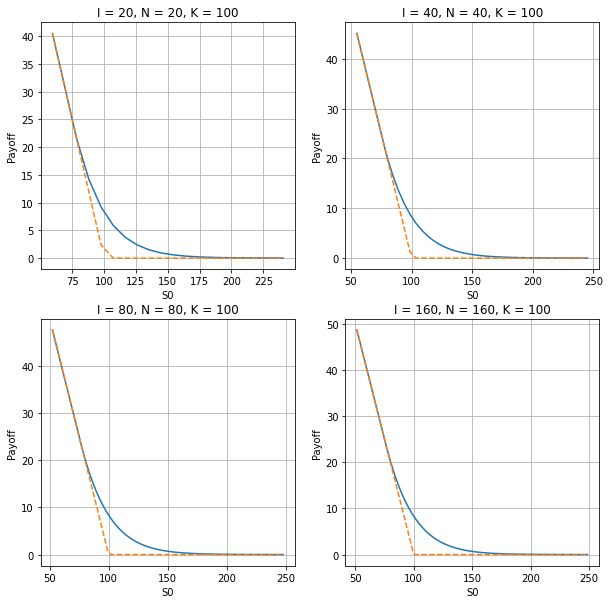

In [38]:
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    N = I
    plot('BDF', I, N)

### N = I/10

In [39]:
Is = np.array([20*2**k for k in range(4)])
Ns = Is//10
err_table = get_err_table('BDF', Is, Ns)
err_table.round(5)

I = 20, N = 2
I = 40, N = 4
I = 80, N = 8
I = 160, N = 16


,I,N,U(s_),e_k,order_alpha_k
0,20,2,12.39408,NaN,NaN
1,40,4,12.95236,0.55828,NaN
2,80,8,13.08102,0.12866,2.15559
3,160,16,13.09934,0.01832,2.83719


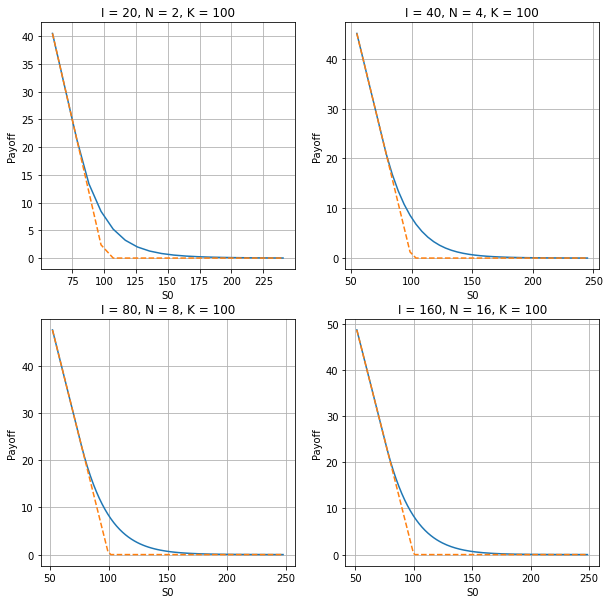

In [40]:
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    N = I//10
    plot('BDF', I, N)

Compared with implicit Euler scheme, higher order scheme can provide a more accurate result with the same I and N